In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# input data

In [2]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))





In [3]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70
--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70


/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected//cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
(100, 100, 100)


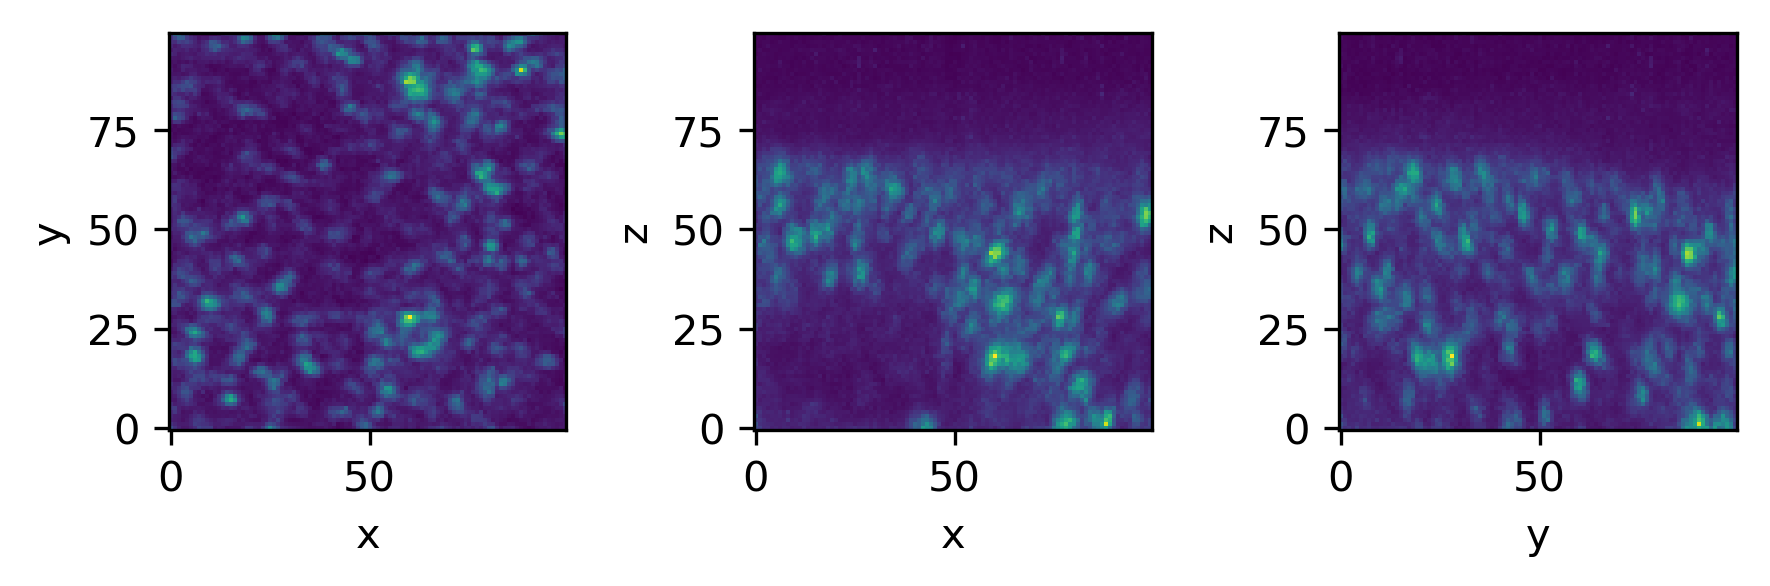

In [4]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [5]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]






/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/trackedFeaturesProcessed.csv


trackId  tracklength        time[s] frameId  lifetime  catIdx  \
0        1           83              0       1    398.23       8   
1        1           83   5.689000e+00       2    398.23       8   
2        1           83   1.137800e+01       3    398.23       8   
3        1           83   1.706700e+01       4    398.23       8   
4        1           83   2.275600e+01       5    398.23       8   

             m_x            m_y            m_z            m_A            m_c  \
0   7.904661e+01   6.464731e+01   8.131298e+01   2.380362e+04   5.097926e+03   
1   7.850739e+01   6.542015e+01   8.129176e+01   2.104784e+04   5.305183e+03   
2   7.839408e+01   6.518394e+01   8.116666e+01   2.085433e+04   5.234626e+03   
3   7.802180e+01   6.560145e+01   8.168228e+01   2.318226e+04   6.263921e+03   
4   7.721728e+01   6.629176e+01   8.136034e+01   2.259943e+04   5.388422e+03   

  m_pval_Ar             s_x            s_y            s_z            s_A  \
0         0    7.861783e+01   6.335770e+01   8.131298e+01   1.455107e+04   
1         0    7.755419e+01   6.464906e+01   8.129176e+01   1.635423e+04   
2         0    7.735373e+01   6.428964e+01   8.116666e+01   7.358672e+03   
3         0    7.704685e+01   6.395467e+01   8.168228e+01   9.978225e+03   
4         0    7.959930e+01   6.657997e+01   8.136034e+01   1.417622e+04   

             s_c       s_pval_Ar  
0   1.618403e+04    9.994436e-01  
1   1.955088e+04    7.208670e-21  
2   1.554692e+04               1  
3   1.407360e+04               1  
4   1.468696e+04   3.412941e-172

# select subset

In [32]:
# select a subset of the tracks, e.g. for displaying only long tracks

allTrackIdsLrgrThanFour = (data[data['tracklength'] >= 4]).drop_duplicates(subset='trackId')['trackId'].values
allTrackIds = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])


print('len(allTrackIdsLrgrThanFour)/len(allTrackIds)')
print(str(len(allTrackIdsLrgrThanFour))+'/'+str(len(allTrackIds)))
print()
print(trackIdsLong)
print('/')
print(allTrackIds)
print()

len(allTrackIdsLrgrThanFour)/len(allTrackIds)
1296/1555

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 23

In [30]:
# from https://matplotlib.org/examples/mplot3d/mixed_subplots_demo.html

def plotTrackOverview(trackId, data, filename=""):

    ################
    # gather the data for plotting
    ################
    
    track = data[data['trackId'] == trackId]
    
    
    m_x = track['m_x'].values.astype(float)
    m_y = track['m_y'].values.astype(float)
    m_z = track['m_z'].values.astype(float)
    m_frameId = track['frameId'].values.astype(float)
    m_intensity = track['m_A'].values.astype(float)
    
    
    
    
    s_x = track['s_x'].values.astype(float)
    s_y = track['s_y'].values.astype(float)
    s_z = track['s_z'].values.astype(float)
    s_frameId = track['frameId'].values.astype(float)
    s_intensity = track['s_A'].values.astype(float)
    
    #center of mass
    comx = np.nanmean(m_x)
    comy = np.nanmean(m_y)
    comz = np.nanmean(m_z)
    
    minx = np.nanmin([np.min(m_x),np.nanmin(s_x)]) 
    maxx = np.nanmax([np.max(m_x),np.nanmax(s_x)]) 
    miny = np.nanmin([np.min(m_y),np.nanmin(s_y)]) 
    maxy = np.nanmax([np.max(m_y),np.nanmax(s_y)]) 
    minz = np.nanmin([np.min(m_z),np.nanmin(s_z)]) 
    maxz = np.nanmax([np.max(m_z),np.nanmax(s_z)]) 
    
    
    ################
    # setup the plot
    ################
    ncols =6
    fig = plt.figure(figsize=plt.figaspect(1/ncols),dpi=300)
    fig.suptitle('Track at a glance')
    
    ################
    # 1st subplot
    ################
    ax = fig.add_subplot(1, ncols, 1)
    
    ax.plot(m_intensity,c='red',lw=0.5)
    ax.scatter(range(0,len(m_intensity)),m_intensity,c='red')
    ax.plot(s_intensity,c='green',lw=0.5)
    ax.scatter(range(0,len(s_intensity)),s_intensity,c='green')
    ax.set_title('trackId = '+str(trackId))
    ax.set_xlabel('frameId')
    ax.set_ylabel('amplitude')
    ax.set_ylim(-5000,50000)
    
    
    
        
    ################
    # 1.5st subplot
    ################
    ax = fig.add_subplot(1, ncols, 2)
    
    ax.plot(m_intensity,c='red',lw=0.5)
    ax.scatter(range(0,len(m_intensity)),m_intensity,c='red')
    ax.plot(s_intensity,c='green',lw=0.5)
    ax.scatter(range(0,len(s_intensity)),s_intensity,c='green')
    ax.set_title('trackId = '+str(trackId))
    ax.set_xlabel('frameId')
    ax.set_ylabel('amplitude')
    
    
    
    #################
    # 2nd subplot
    #################
    ax = fig.add_subplot(1, ncols, 3, projection='3d')
    
    ax.plot3D(m_x, m_y, m_z, 'grey')
    ax.scatter3D(m_x, m_y, m_z,c='red',s=100);
    
    ax.plot3D(s_x, s_y, s_z, 'grey')
    ax.scatter3D(s_x, s_y, s_z,c='green',s=100);
    
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_zlabel('z [px]')
    ax.set_title('context +- 10px')
    ax.set_xlim(comx-10,comx+10)
    ax.set_ylim(comy-10,comy+10)
    ax.set_zlim(comz-10,comz+10)
    
    
    #################
    # 3rd subplot
    #################
    ax = fig.add_subplot(1, ncols, 4, projection='3d')
    
    ax.plot3D(m_x, m_y, m_z, 'grey')
    ax.scatter3D(m_x, m_y, m_z,c='red',s=100);
    
    ax.plot3D(s_x, s_y, s_z, 'grey')
    ax.scatter3D(s_x, s_y, s_z,c='green',s=100);
    
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_zlabel('z [px]')
    ax.set_title('master(red) slave(green)')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_zlim(minz,maxz)
    
    ################
    # 4th subplot
    ################
    ax = fig.add_subplot(1, ncols, 5, projection='3d')
    ax.plot3D(m_x, m_y, m_z, 'grey')
    ax.scatter3D(m_x, m_y, m_z,c=m_frameId, cmap='plasma',s=100);
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_zlabel('z [px]')
    ax.set_title('master (time: blue -> yellow)')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_zlim(minz,maxz)
    
    ################
    # 5th subplot
    ################
    ax = fig.add_subplot(1, ncols, 6, projection='3d')
    ax.plot3D(s_x, s_y, s_z, 'grey')
    ax.scatter3D(s_x, s_y, s_z,c=s_frameId, cmap='plasma',s=100);
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_zlabel('z [px]')
    ax.set_title('slave (time: blue -> yellow)')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_zlim(minz,maxz)
    
    plt.tight_layout ()
    
    if(filename == ""):
        plt.show()
    else:
        plt.savefig(filename)
    plt.close()
    

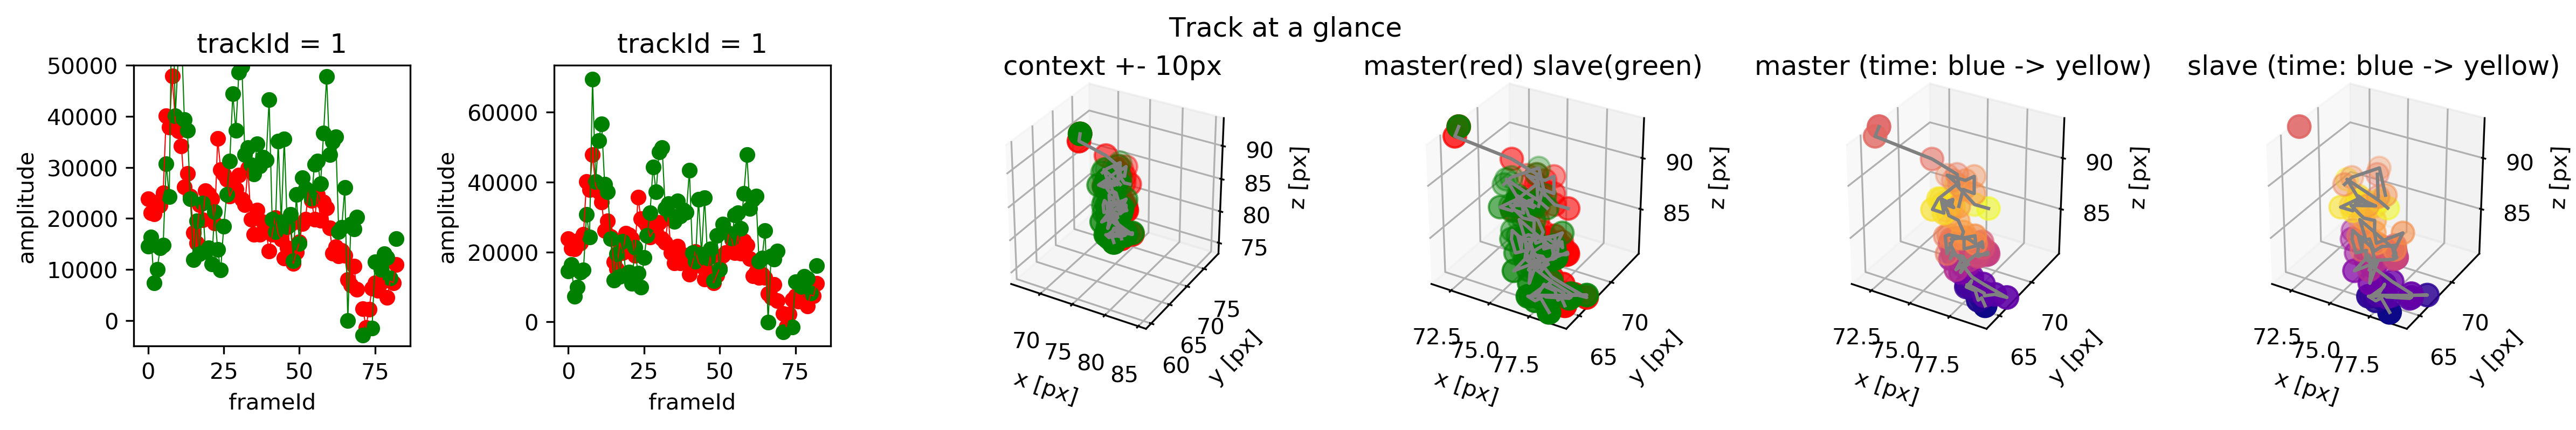

In [31]:
trackSelectionId = 0
trackSelection = allTrackIdsLrgrThanFour
trackId = trackSelection[trackSelectionId]

track = data[data['trackId'] == trackId]
    

plotTrackOverview(trackId,data,"")

In [33]:
trackSelection = allTrackIdsLrgrThanFour
counter = 0
for trackId in trackSelection:
    if (counter%100 == 0 ):
        print(str(counter)+'/'+str(len(trackSelection)))
    filename = outputDataFolder+'/'+"allTrackIdsLrgrThanFour_"+str(trackId)+".png"
    plotTrackOverview(trackId,data,filename)
    counter =counter+1
    


0/1296
100/1296
200/1296
300/1296
400/1296
500/1296
600/1296
700/1296
800/1296
900/1296
1000/1296
1100/1296
1200/1296


In [43]:
import csv
f = open(outputDataFolder+'/'+"allTrackIdsLrgrThanFour_"+"evaluationTemplate.csv", 'w')
writer = csv.writer(f)
writer.writerow(['track id', 'visual assessment signal (1) or noise (0)'])
for trackId in trackSelection:
        writer.writerow([trackId])
f.close()

In [47]:
print(len(trackSelection))
magickCommand = "magick convert "
imageCounter = 0
stackCounter = 0
nImagesPerStack = 15
for trackId in trackSelection:
    filename = "trackOverview_"+str(trackId)+".png"
    magickCommand = magickCommand + " "+ filename

    if(imageCounter % 15 == 0 and imageCounter!=0):
        magickCommand = magickCommand + " -append stack"+str(stackCounter)+".png\n magick convert "
        stackCounter = stackCounter +1
        
    imageCounter = imageCounter +1    
magickCommand = magickCommand + " -append stack"+str(stackCounter)+".png\n"    

    
print(magickCommand)

143
magick convert  trackOverview_8.png trackOverview_32.png trackOverview_33.png trackOverview_34.png trackOverview_38.png trackOverview_40.png trackOverview_42.png trackOverview_46.png trackOverview_51.png trackOverview_53.png trackOverview_54.png trackOverview_57.png trackOverview_58.png trackOverview_60.png trackOverview_65.png trackOverview_66.png -append stack0.png
 magick convert  trackOverview_67.png trackOverview_68.png trackOverview_75.png trackOverview_77.png trackOverview_78.png trackOverview_83.png trackOverview_84.png trackOverview_88.png trackOverview_94.png trackOverview_95.png trackOverview_98.png trackOverview_101.png trackOverview_102.png trackOverview_109.png trackOverview_110.png -append stack1.png
 magick convert  trackOverview_111.png trackOverview_112.png trackOverview_114.png trackOverview_115.png trackOverview_122.png trackOverview_123.png trackOverview_124.png trackOverview_129.png trackOverview_130.png trackOverview_131.png trackOverview_132.png trackOvervie

In [48]:
import os
os.system(magickCommand)

0

1999


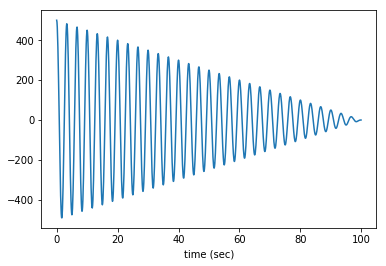

In [84]:
# Testing the autocorrelation of numpy

import numpy as np
from matplotlib import pyplot as plt

num_samples = 1000
dt = 0.1    
t = dt*np.arange(num_samples)   

def autocor(x):
    result = np.correlate(x,x,mode='full')
    print(len(result))
    return result[999:]

def f(freq):
    return np.sin(2*np.pi*freq*t)    

plt.plot(t, autocor(f(.3)))
plt.xlabel("time (sec)")
plt.show()                   

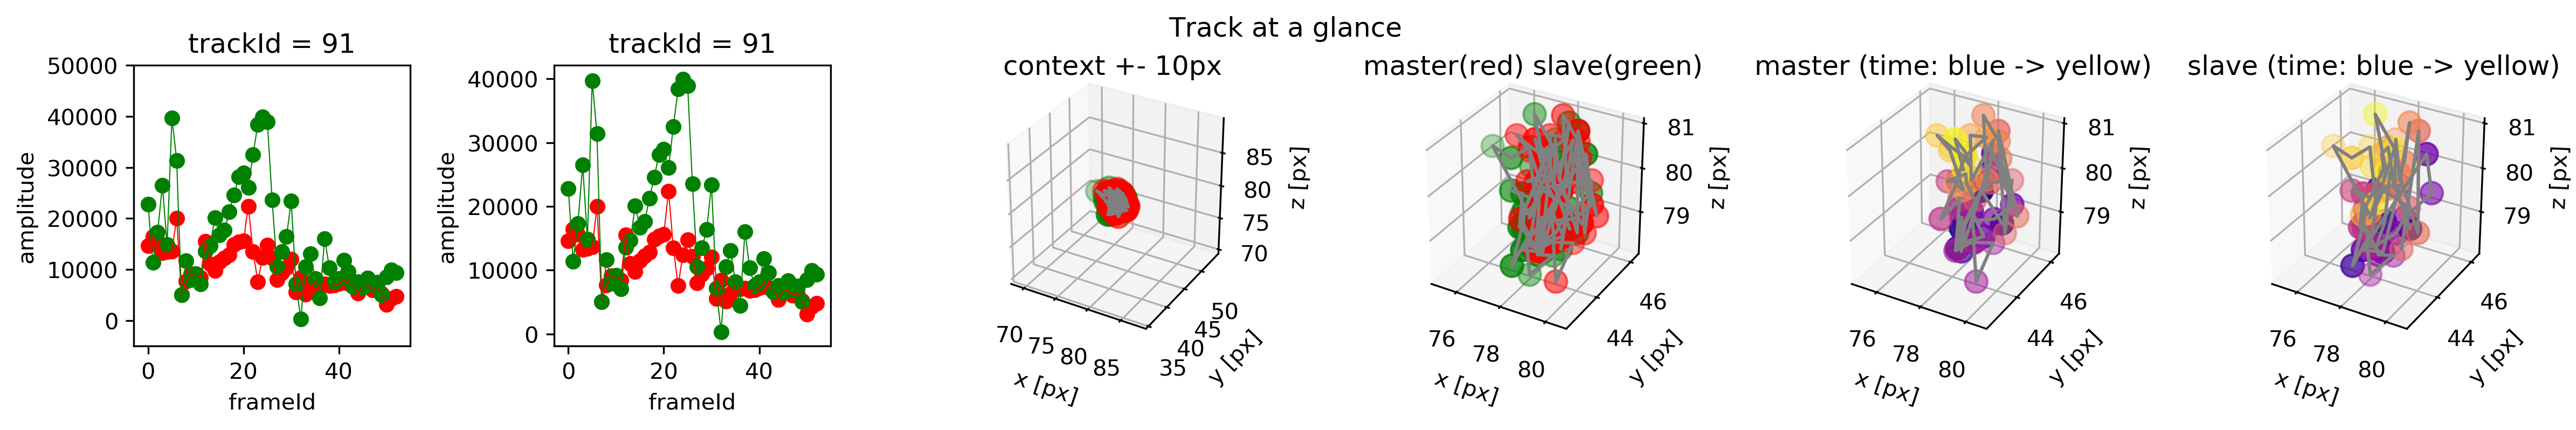

17611619.8769


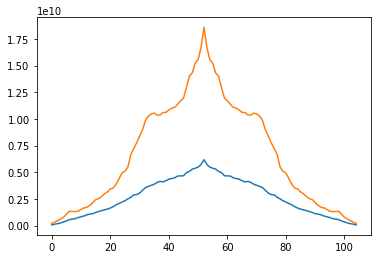

In [110]:

trackId = 91


plotTrackOverview(trackId,data,"")

track = data[data['trackId'] == trackId]
    
    
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)




s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)

plt.plot(np.correlate(m_intensity,m_intensity,mode='full'))
plt.plot(np.correlate(s_intensity,s_intensity,mode='full'))

print(np.var(m_intensity))

var_signal = np.var(m_intensity)

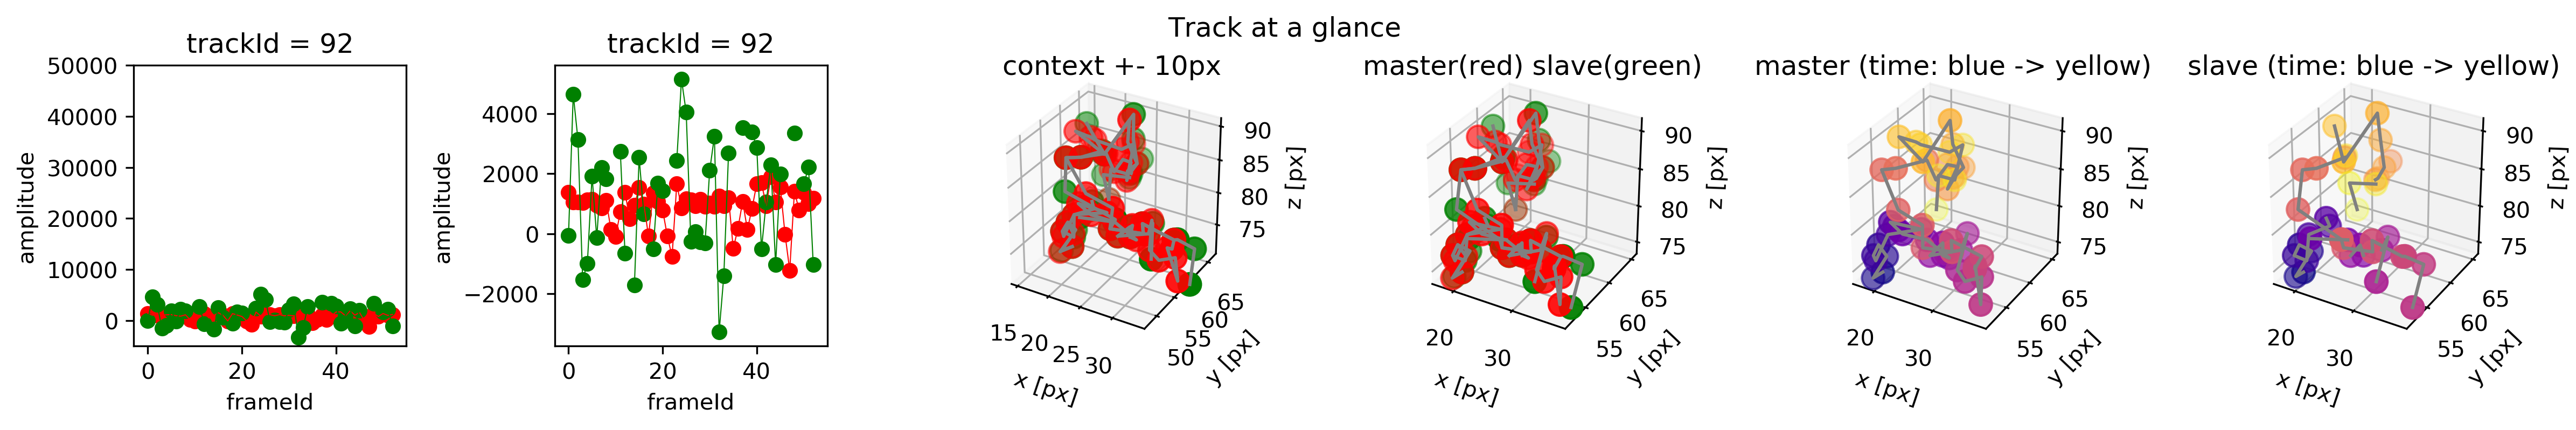

383904.58194


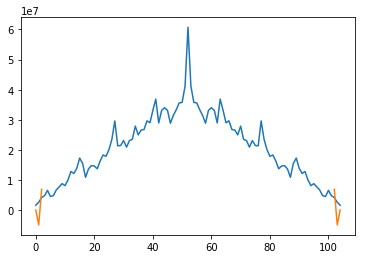

In [111]:

trackId = 92


plotTrackOverview(trackId,data,"")

track = data[data['trackId'] == trackId]
    
    
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)




s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)

plt.plot(np.correlate(m_intensity,m_intensity,mode='full'))
plt.plot(np.correlate(s_intensity,s_intensity,mode='full'))

print(np.var(m_intensity))
    
    
var_noise = np.var(m_intensity)

In [97]:
print(var_signal/var_noise)

45.8749926555


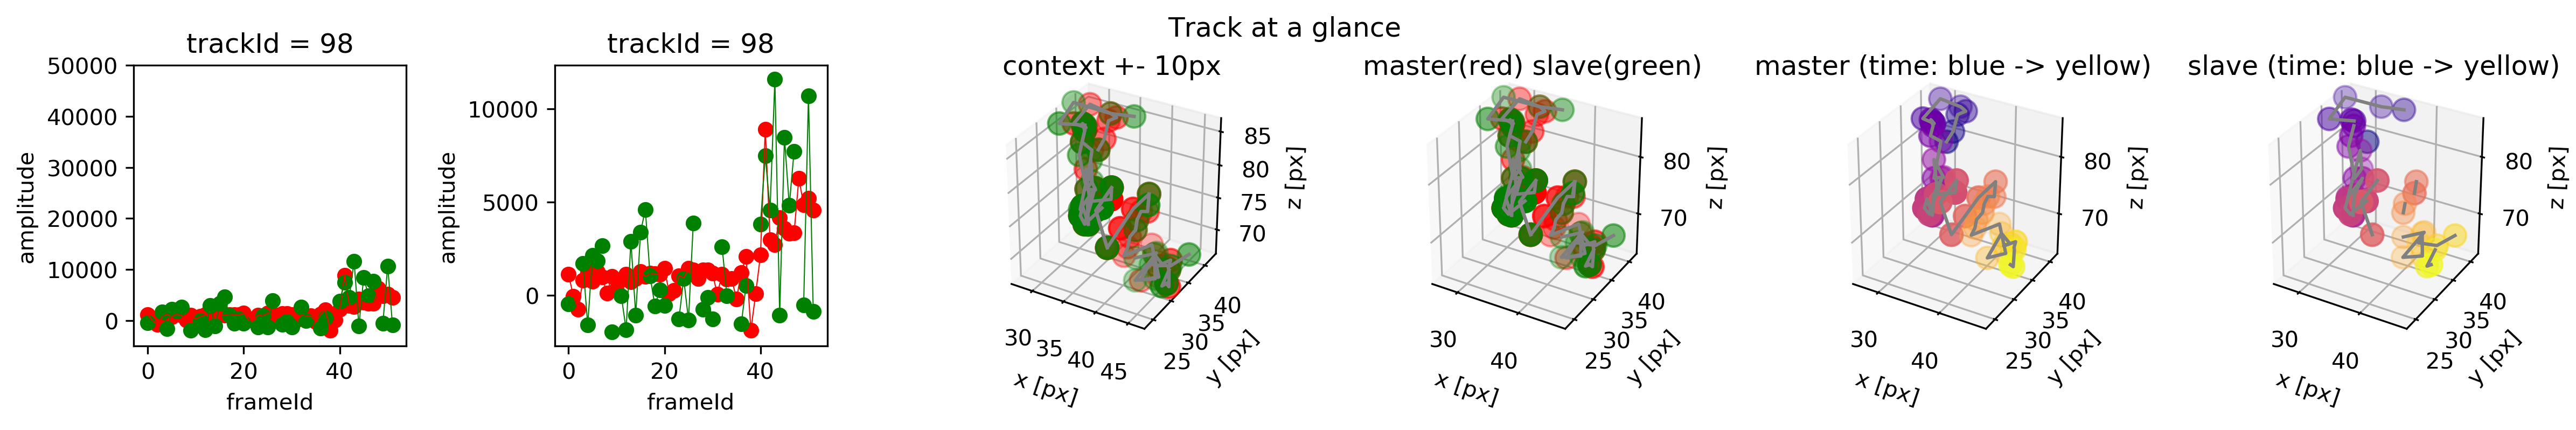

3307696.1823


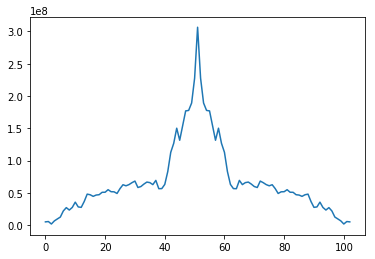

In [112]:

trackId = 98


plotTrackOverview(trackId,data,"")

track = data[data['trackId'] == trackId]
    
    
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)




s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)

plt.plot(np.correlate(m_intensity,m_intensity,mode='full'))
plt.plot(np.correlate(s_intensity,s_intensity,mode='full'))

print(np.var(m_intensity))
    
    
var_above_noise = np.var(m_intensity)

In [113]:
print(var_above_noise/var_noise)

8.61593306748


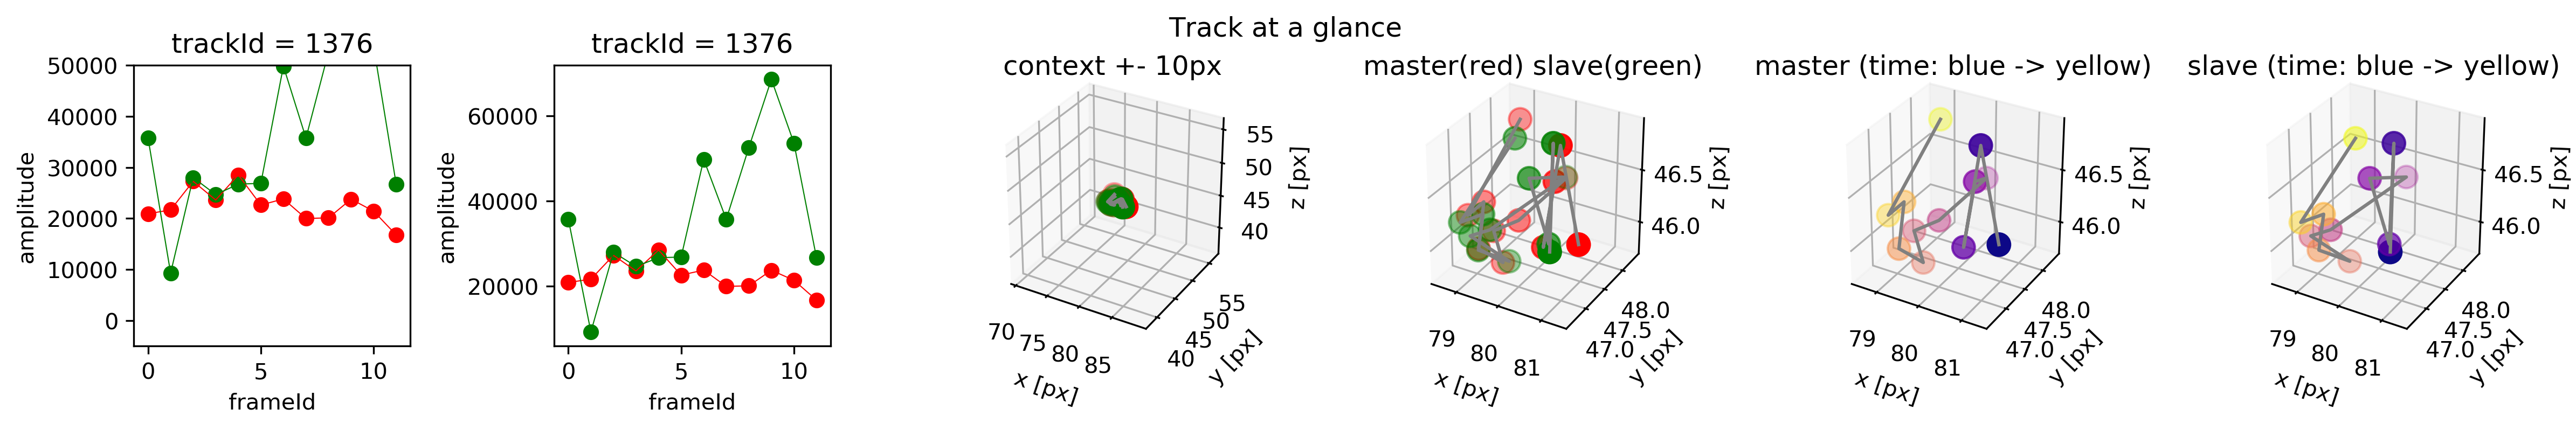

9408857.77581


In [120]:

trackId = 1376


plotTrackOverview(trackId,data,"")

track = data[data['trackId'] == trackId]
    
    
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)




s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)

#plt.plot(np.correlate(m_intensity,m_intensity,mode='full'))
#plt.plot(np.correlate(s_intensity,s_intensity,mode='full'))

print(np.var(m_intensity))
    
    
var_short_a = np.var(m_intensity)

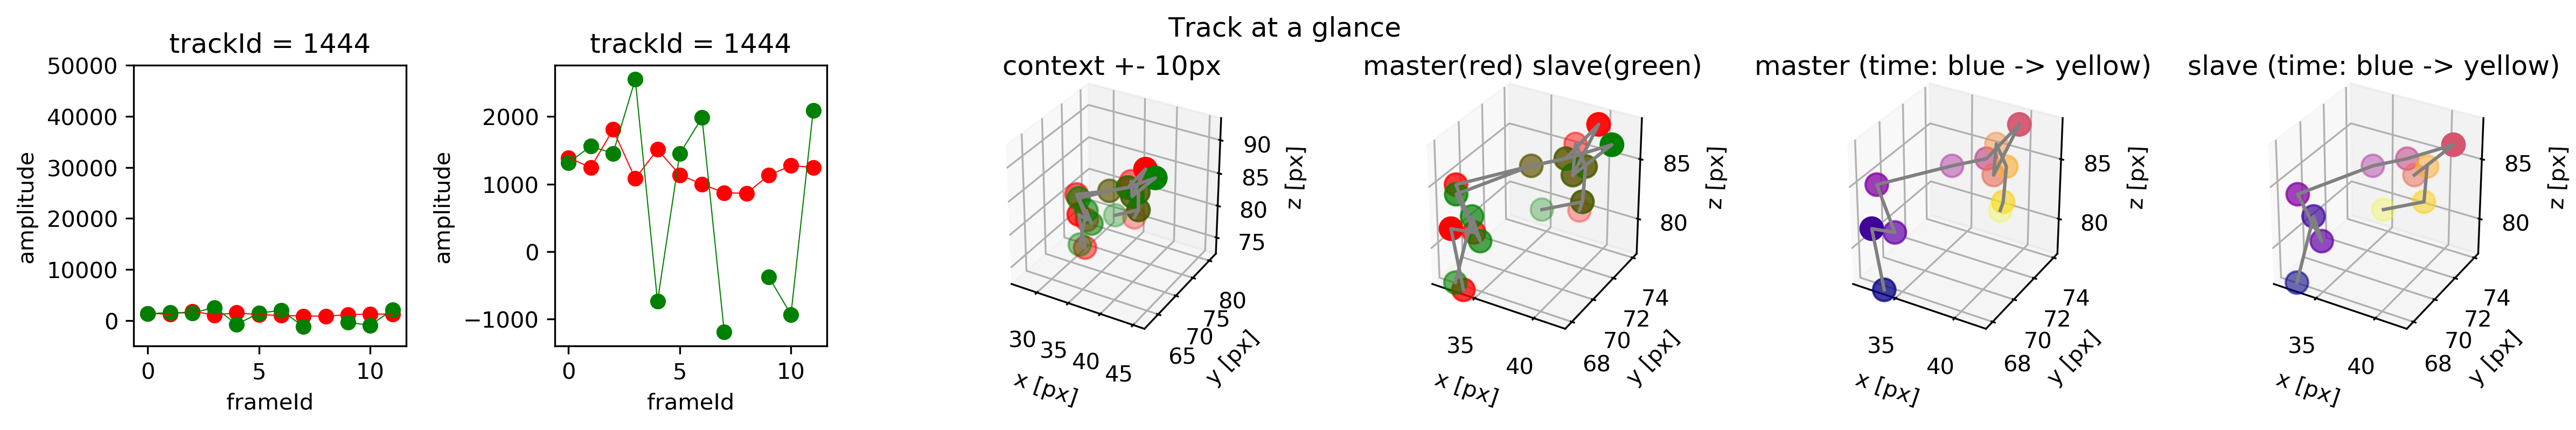

66404.3410917


In [119]:

trackId = 1444


plotTrackOverview(trackId,data,"")

track = data[data['trackId'] == trackId]
    
    
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)




s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)

#plt.plot(np.correlate(m_intensity,m_intensity,mode='full'))
#plt.plot(np.correlate(s_intensity,s_intensity,mode='full'))

print(np.var(m_intensity))
    
    
var_short_b = np.var(m_intensity)

In [121]:
print(var_short_a/var_short_b)

141.690401879
